In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

pd.options.display.float_format = '{:.2f}'.format

from statsmodels.graphics.tsaplots import plot_acf
from model_SARIMA import *
from model_naiv import *
from test_mean import *
from test_correlation import *
from time_series import *
from cross_validation import *


warnings.filterwarnings("ignore")

/Users/alex/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Datensatz lesen

In [2]:
df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)
df.columns = df.columns.str.lower()

1 Store wählen

In [3]:
# Filtern nach Store
store_number = 2
store = df[df['store'] == store_number].copy()

# Datum als Index setzen
store.set_index('date', inplace=True)

# Spalte Weekly_Sales extrahieren
sales = store['weekly_sales']
sales = sales.asfreq('W-FRI')

Zeitreihe plotten

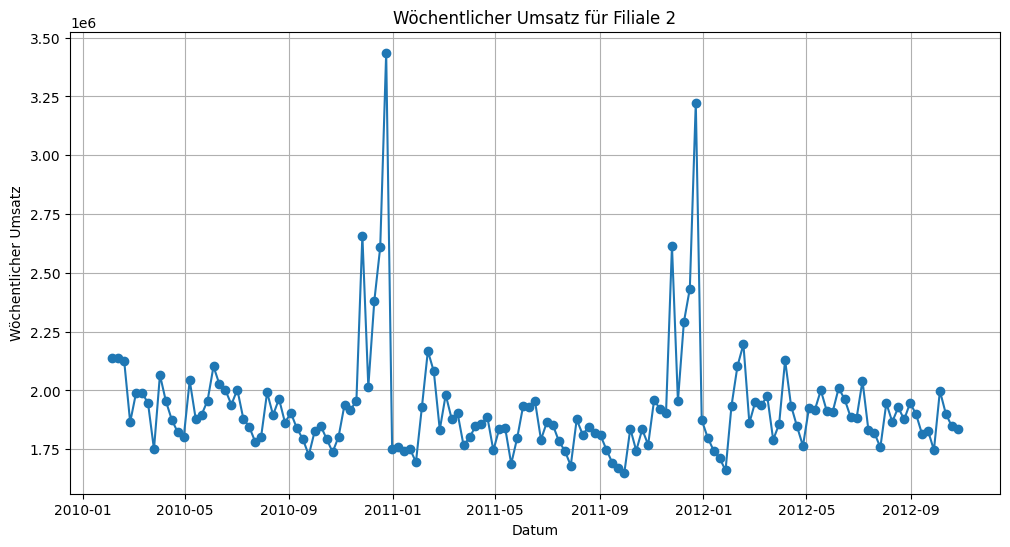

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(sales, marker='o', linestyle='-')
plt.title('Wöchentlicher Umsatz für Filiale {}'.format(store_number))
plt.xlabel('Datum')
plt.ylabel('Wöchentlicher Umsatz')
plt.grid(True)
plt.show()

Seasonal

In [5]:
#seasonal_plot(sales)
#seasonal_subseries_plot(sales)
#acf_plot(sales)
#lag_plot(sales)
#decompose(sales)

Modell wählen

In [6]:
#model_type = 'SARIMA'
#model_type = 'Naive'
model_type = 'Additive'

Residuen und Fitted Values berechnen

In [7]:
if model_type == 'Naive':
    resid, fitted_values = build_naive_model(sales)

if model_type == 'Additive':
    resid, fitted_values, y_train, y_test = build_naive_additive(sales, sample = 'IS')
    resid_oos, fitted_values_oos, y_train, y_test = build_naive_additive(sales, sample = 'OOS')

if model_type == 'SARIMA':
    sarima_params  = optimal_orders_5.get(str(store_number))
    order = tuple(sarima_params["order"])
    seasonal_order = tuple(sarima_params["seasonal_order"])

    sarima_model = build_SARIMA(sales, order = order, seasonal_order = seasonal_order)
    resid = sarima_model.resid.iloc[1:]
    fitted_values = sarima_model.fittedvalues.iloc[1:]
    sarima_model.summary()

Plot

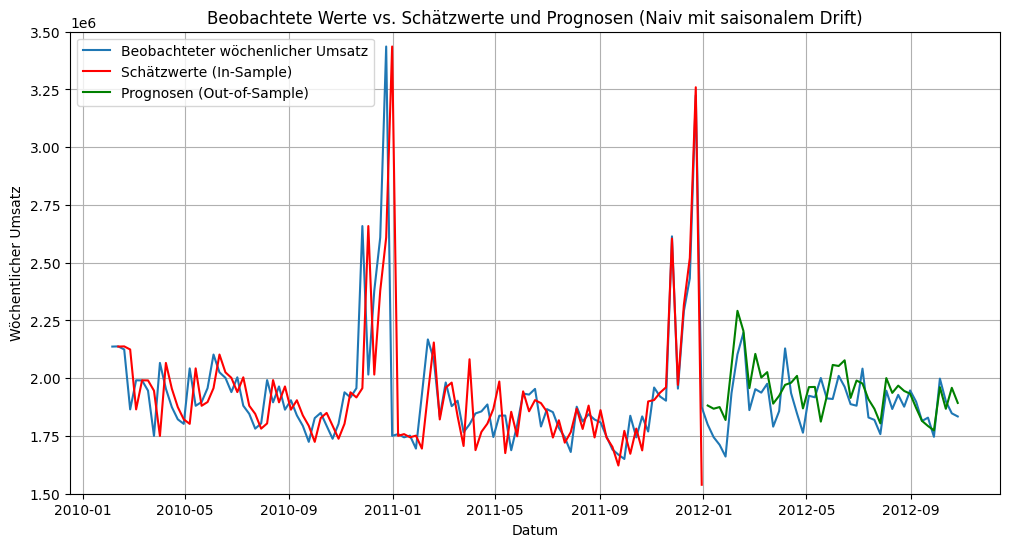

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(sales, label='Beobachteter wöchenlicher Umsatz')
plt.plot(fitted_values, color='red', label='Schätzwerte (In-Sample)')
plt.plot(fitted_values_oos, color='green', label='Prognosen (Out-of-Sample)')
plt.title('Beobachtete Werte vs. Schätzwerte und Prognosen (Naiv mit saisonalem Drift)')
plt.xlabel('Datum')
plt.ylabel('Wöchentlicher Umsatz')
plt.legend()
plt.grid(True)
plt.ylim(1500000, 3500000)
plt.show()


In [9]:
pd.set_option('display.max_rows', None)
non_nan_count = resid.count()
print(non_nan_count)
print(resid)

99
2010-02-12        820.04
2010-02-19     -13357.96
2010-02-26    -259354.27
2010-03-05     125915.86
2010-03-12       -529.35
2010-03-19     -44412.90
2010-03-26    -195873.07
2010-04-02     315989.91
2010-04-09    -111498.51
2010-04-16     -79731.27
2010-04-23     -52967.01
2010-04-30     -19540.64
2010-05-07     240131.42
2010-05-14    -161829.35
2010-05-21      16184.74
2010-05-28      60176.79
2010-06-04     145426.04
2010-06-11     -77001.17
2010-06-18     -23901.80
2010-06-25     -61709.87
2010-07-02      64013.55
2010-07-09    -123038.02
2010-07-16     -35022.83
2010-07-23     -64162.08
2010-07-30      22528.45
2010-08-06     187663.82
2010-08-13     -96308.93
2010-08-20      68734.18
2010-08-27    -100494.74
2010-09-03      40767.60
2010-09-10     -65479.26
2010-09-17     -45225.23
2010-09-24     -69346.38
2010-10-01     102883.21
2010-10-08      22481.01
2010-10-15     -55565.95
2010-10-22     -56407.85
2010-10-29      64807.47
2010-11-05     136306.30
2010-11-12     -22248.

Korrelations Tests

Box Pierce Test: 0.0039
Ljung Box Test: 0.0018
Monti Test: 0.0000
Fisher Test: 0.0188
Fisher Test: 0.0003
Pena Rodriguez Test: 0.0000
Breusch–Godfrey (OOS): 0.0018
Run Test: 0.0062
Durbin Watson: 2.7248


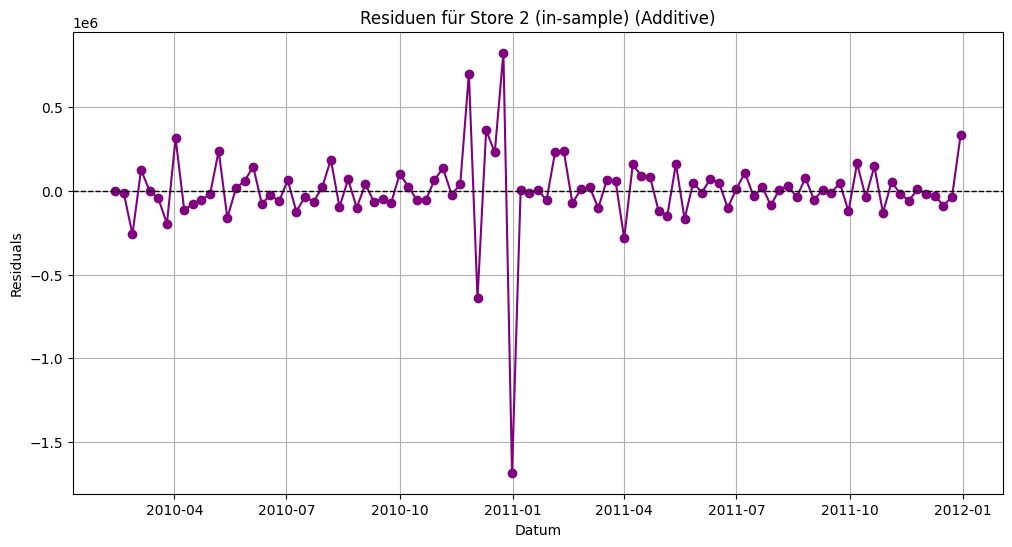

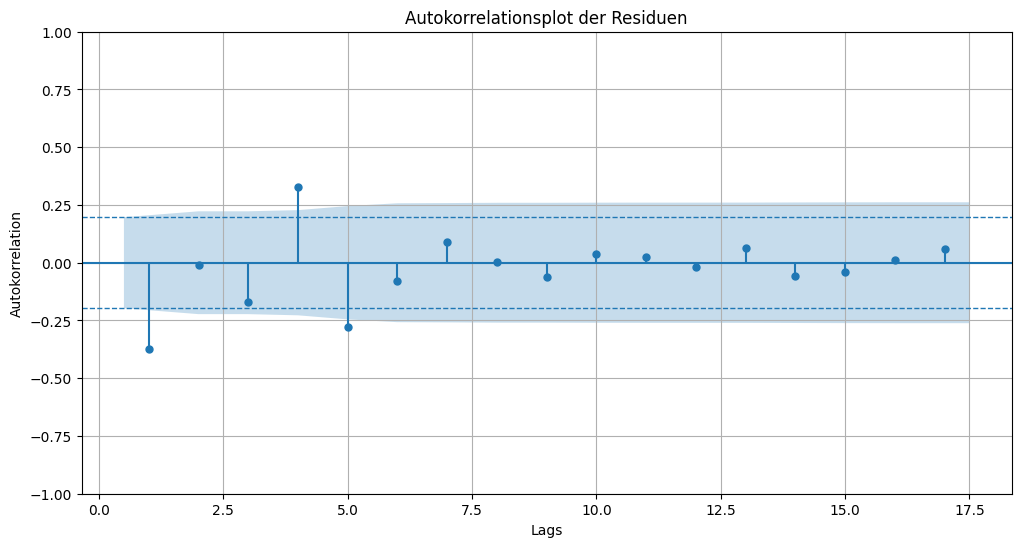

In [10]:
box_pierce_test(residuals = resid, store_num = store_number, model = model_type, lags = 20)
ljung_box_test(residuals = resid, store_num = store_number, model = model_type, lags = 20)
monti_test(residuals = resid, store_num = store_number, model = model_type, m = 20)
fisher_test(residuals = resid, store_num = store_number, model = model_type, version = "acf", m = 20)
fisher_test(residuals = resid, store_num = store_number, model = model_type, version = "pacf", m = 20)
pena_rodriguez_test_original(residuals = resid, store_num = store_number, model = model_type, m = 20)


if model_type == 'SARIMA':
    breusch_godfrey_test(model = sarima_model, lags = 20)
if model_type == 'Additive':
    breusch_godfrey_manuell(resid, lags = 20)

run_test(residuals = resid)
durbin_watson_test(residuals = resid)

#Residuen Plot
plt.figure(figsize=(12, 6))
plt.plot(resid, marker='o', linestyle='-', color='purple')
plt.title('Residuen für Store {} (in-sample) ({})'.format(store_number, model_type))
plt.xlabel('Datum')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.grid(True)
plt.show()

#ACF Plot
acf_resid_plot(resid, lags = 17, print_results = True)



Mittelwert Tests

In [11]:
print(f"Mittelwert der Residuen: {resid.mean():.4f}")


t_test(resid)
wilcoxon_test(resid)
vorzeichen_test(resid)
kolmogorov_test(resid)



Mittelwert der Residuen: 1250.4239
T-Test: 0.9591
Wilcoxon Test: 0.8991
Sign Test: 1.0000
Kolmogorov Test: 0.0002


(0.21461518202940547, 0.0001757671471766077)

SMAPE

In [12]:
# SMAPE berechnen

denom = (np.abs(y_train) + np.abs(fitted_values))
# Vermeide Division durch 0
mask = denom != 0
smape = 100 * np.mean(2 * np.abs(fitted_values[mask] - y_train[mask]) / denom[mask])
print(f"SMAPE: {smape:.2f}%")

SMAPE: 5.90%


Kreuz Validierung

In [13]:
#if model_type == 'SARIMA':
#    cv_df, train_size = cross_validation_SARIMA(sales, order = order, seasonal_order = seasonal_order)
#if model_type == 'Naive':
#    cv_df = cross_validation_naive(sales)
#if model_type == 'Additive':
#    residuals, fitted_series, y_train, y_test = build_naive_additive(sales, sample = 'OOS', train_ratio=0.7)



Plot

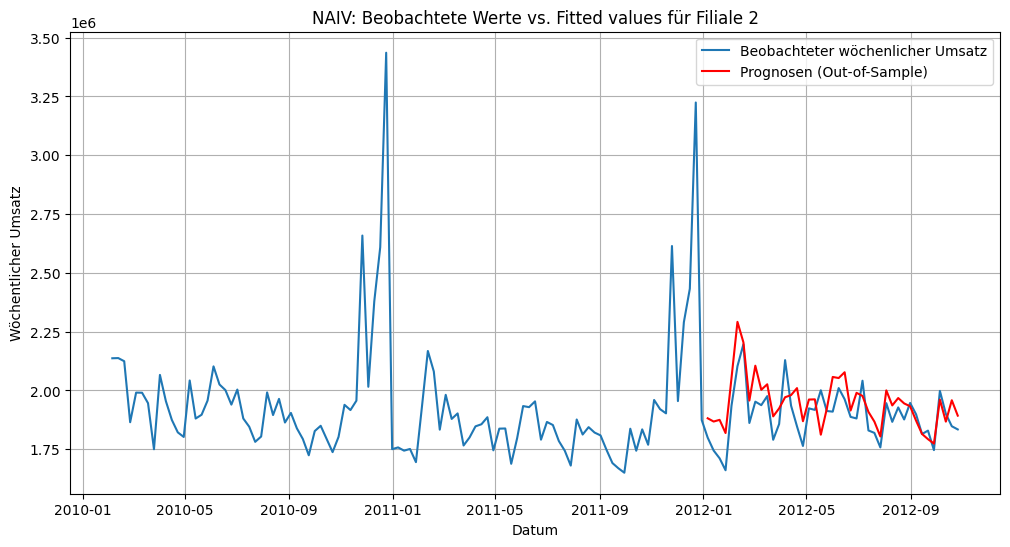

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(sales, label='Beobachteter wöchenlicher Umsatz')
plt.plot(fitted_values_oos, color='red', label='Prognosen (Out-of-Sample)')
plt.title('NAIV: Beobachtete Werte vs. Fitted values für Filiale {}'.format(store_number))
plt.xlabel('Datum')
plt.ylabel('Wöchentlicher Umsatz')
plt.legend()
plt.grid(True)
plt.show()

Korrelations Tests

43
Box Pierce Test: 0.0965
Ljung Box Test: 0.0632
Monti Test: 0.0460
Fisher Test: 0.1573
Fisher Test: 0.1534
Pena Rodriguez Test: 0.0604
Run Test: 0.3560
Durbin Watson: 0.0029


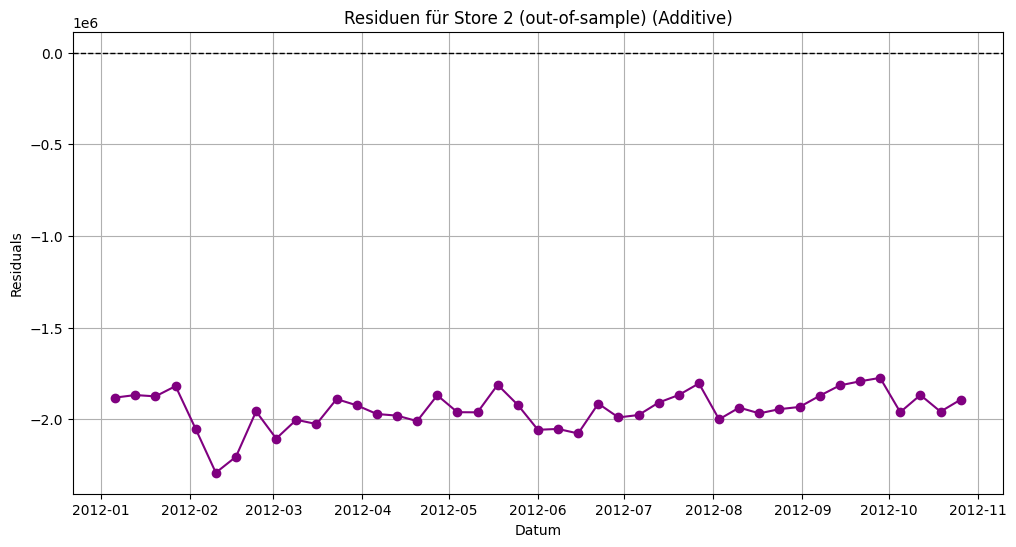

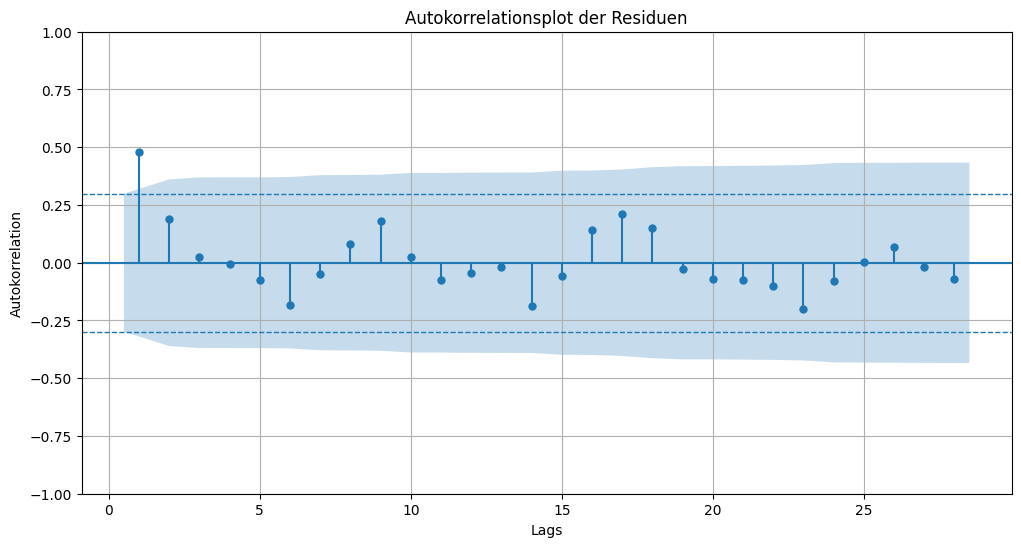

In [15]:
errors = resid_oos - y_test
print(len(errors))


box_pierce_test(residuals = errors, store_num = store_number, model = model_type, lags = 9)
ljung_box_test(residuals = errors, store_num = store_number, model = model_type, lags = 9)
monti_test(residuals = errors, store_num = store_number, model = model_type, m = 9)
fisher_test(residuals = errors, store_num = store_number, model = model_type, version = "acf", m = 9)
fisher_test(residuals = errors, store_num = store_number, model = model_type, version = "pacf", m = 9)
pena_rodriguez_test_original(residuals = errors, store_num = store_number, model = model_type, m = 9)


if model_type == 'SARIMA':
    breusch_godfrey_manuell(errors = errors, lags = 9)
if model_type == 'Naive':
    breusch_godfrey_manuell(errors = errors, lags = 9)


run_test(residuals = errors)

durbin_watson_test(residuals = errors)

#Residuen Plot
plt.figure(figsize=(12, 6))
plt.plot(errors, marker='o', linestyle='-', color='purple')
plt.title('Residuen für Store {} (out-of-sample) ({})'.format(store_number, model_type))
plt.xlabel('Datum')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.grid(True)
plt.show()


acf_resid_plot(residuals = errors, lags = 28, print_results = True)


Mittelwert Tests

In [16]:
print(f'Mittelwert der Errors: {errors.mean()}')

t_test(errors)
wilcoxon_test(errors)
binomial_test(errors)
kolmogorov_test(errors)



Mittelwert der Errors: -1947830.3283720932
T-Test: 0.0000
Wilcoxon Test: 0.0000
Binomial Test: 0.0000
Kolmogorov Test: 0.0000


(1.0, 0.0)

SMAPE

In [17]:
denom = (np.abs(y_test) + np.abs(fitted_values_oos))
    # Vermeide Division durch 0
mask = denom != 0
smape = 100 * np.mean(2 * np.abs(fitted_values_oos[mask] - y_test[mask]) / denom[mask])


print(f"SMAPE: {smape:.2f}%")

SMAPE: 4.09%
